In [251]:
# Import necassary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns

np.random.seed(15789034)

In [252]:
# read in the three datasets provided
data1 = pd.read_csv("../data/raw/datatest.csv", parse_dates=True)

data2 = pd.read_csv("../data/raw/datatest2.csv", parse_dates=True)

data3 = pd.read_csv("../data/raw/datatraining.csv", parse_dates=True)

print(f"{data1.shape}\n{data2.shape}\n{data3.shape}")

(2665, 7)
(9752, 7)
(8143, 7)


In [253]:
#concat datasets together so we can split it ourselves
data = pd.concat([data1, data2, data3])
data.to_csv("../data/processed/full_dataset.csv")
print(data.shape)

(20560, 7)


## Exploratory Data Analysis

In [254]:
data['date_time'] = pd.to_datetime(data['date']).values.astype("float64")
print(data.head())
print(data.dtypes)
print(data.describe())
print(max(pd.to_datetime(data["date"])), min(pd.to_datetime(data["date"])))



             date  Temperature  Humidity       Light         CO2  \
0  2/2/2015 14:19      23.7000    26.272  585.200000  749.200000   
1  2/2/2015 14:19      23.7180    26.290  578.400000  760.400000   
2  2/2/2015 14:21      23.7300    26.230  572.666667  769.666667   
3  2/2/2015 14:22      23.7225    26.125  493.750000  774.750000   
4  2/2/2015 14:23      23.7540    26.200  488.600000  779.000000   

   HumidityRatio  Occupancy     date_time  
0       0.004764          1  1.422887e+18  
1       0.004773          1  1.422887e+18  
2       0.004765          1  1.422887e+18  
3       0.004744          1  1.422887e+18  
4       0.004767          1  1.422887e+18  
date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
date_time        float64
dtype: object
        Temperature      Humidity         Light           CO2  HumidityRatio  \
count  20560.000000  20560.000000

<Axes: >

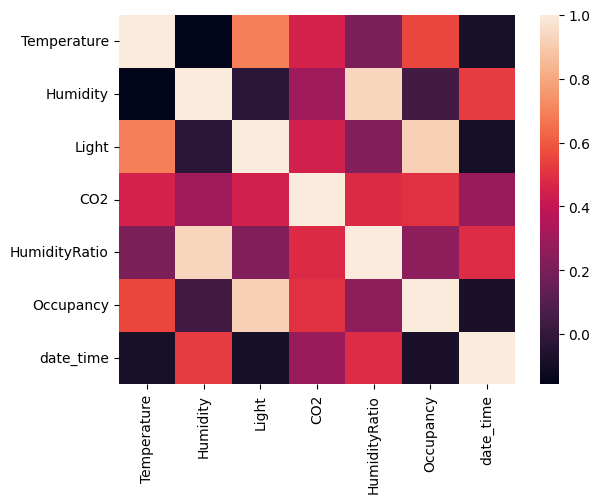

In [255]:
correlations = data.drop("date", axis = 1).corr()
sns.heatmap(correlations)

<Axes: xlabel='Humidity', ylabel='Temperature'>

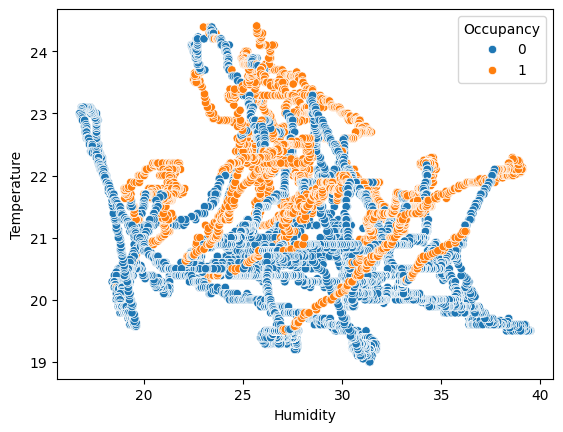

In [256]:
sns.scatterplot(x=data["Humidity"], y=data["Temperature"], hue=data["Occupancy"])

<Axes: xlabel='date_time', ylabel='Temperature'>

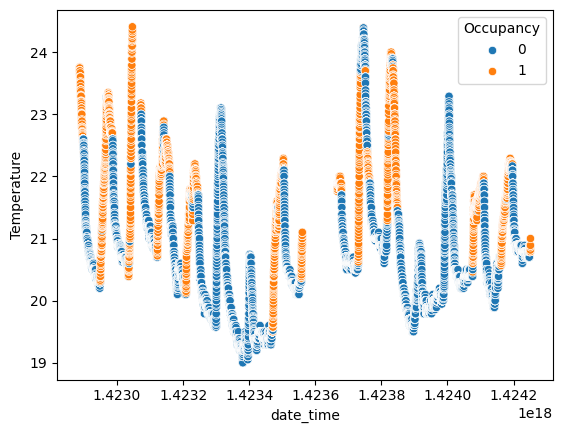

In [257]:
sns.scatterplot(x=data["date_time"], y=data["Temperature"], hue=data["Occupancy"])

<Axes: xlabel='date_time', ylabel='Humidity'>

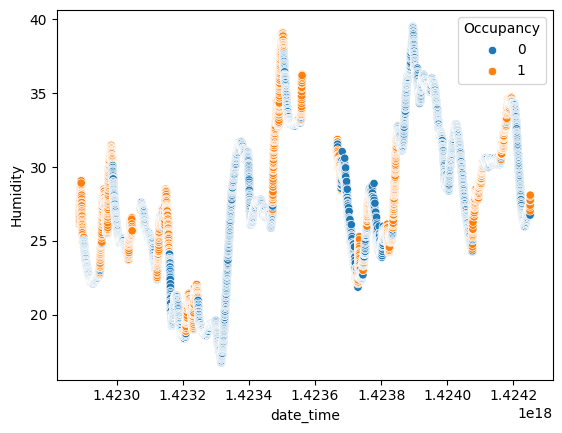

In [258]:
sns.scatterplot(x=data["date_time"], y=data["Humidity"], hue=data["Occupancy"])

<Axes: xlabel='date_time', ylabel='Light'>

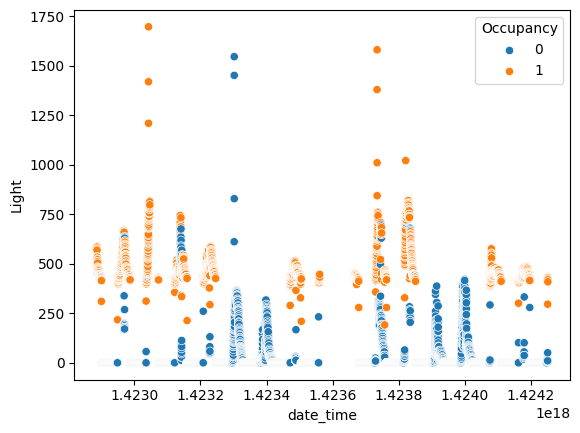

In [259]:
sns.scatterplot(x=data["date_time"], y=data["Light"], hue=data["Occupancy"])

We are predicting the Occupancy variable

In [260]:
# Split data into test, train, and validation
X = data.drop(["Occupancy", 'date'], axis=1)
y = data["Occupancy"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.125)
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)


(14392, 6)
(4112, 6)
(2056, 6)


In [261]:
#Run KNN with neighbers in 1 - 25, odd
train_accuracies = {}
val_accuracies = {}
neighbors = np.arange(1,26, 2)
print(neighbors)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    val_accuracies[neighbor] = knn.score(X_validate, y_validate)

[ 1  3  5  7  9 11 13 15 17 19 21 23 25]


Train Accuracies {1: 1.0, 3: 0.9971511951083936, 5: 0.9960394663702057, 7: 0.9948582545858811, 9: 0.9946498054474708, 11: 0.9940244580322402, 13: 0.9936770428015564, 15: 0.9922873818788216, 17: 0.9904808226792663, 19: 0.9900639244024458, 21: 0.9899249583101724, 23: 0.9898554752640356, 25: 0.9887437465258477}
Validation Accuracies {1: 0.9907587548638133, 3: 0.9922178988326849, 5: 0.9922178988326849, 7: 0.9936770428015564, 9: 0.9936770428015564, 11: 0.992704280155642, 13: 0.9897859922178989, 15: 0.9897859922178989, 17: 0.9878404669260701, 19: 0.9873540856031129, 21: 0.9878404669260701, 23: 0.9888132295719845, 25: 0.9878404669260701}
7


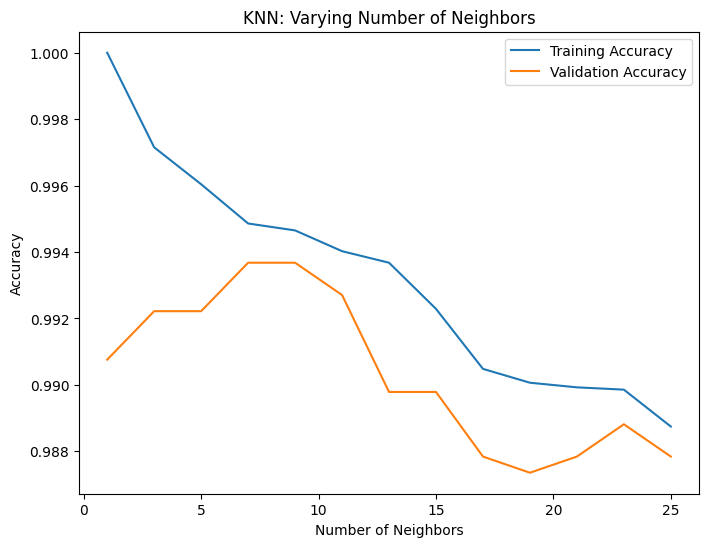

In [262]:
print(f"Train Accuracies {train_accuracies}\nValidation Accuracies {val_accuracies}")
optimal_neighbor = max(val_accuracies, key=val_accuracies.get)
print(optimal_neighbor)
best_knn = KNeighborsClassifier(n_neighbors=optimal_neighbor)
best_knn.fit(X_train, y_train)
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, val_accuracies.values(), label="Validation Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [263]:
# Gaussian Naive Bayes 
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(X_train, y_train)

GaussianNB()

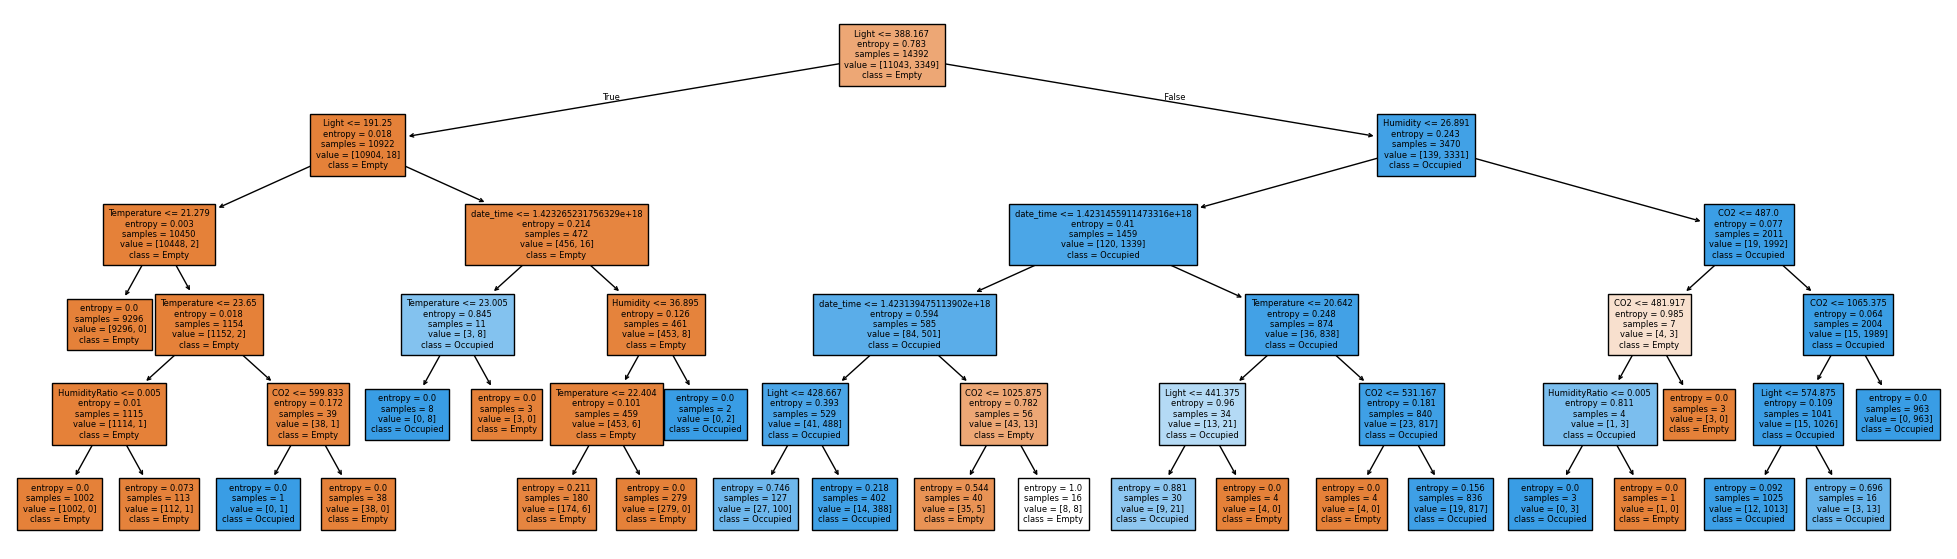

In [264]:
#Decision Tree
depth_limit = 5
features = ["Temperature","Humidity","Light","CO2","HumidityRatio", "date_time"]
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=depth_limit)
decision_tree.fit(X_train[features], y_train)
plt.figure(figsize=[25,7])
plot_tree(decision_tree=decision_tree, filled=True, class_names=["Empty", "Occupied"], feature_names=features, fontsize=6)
plt.show()


In [265]:
# Predict on the train data
y_pred_train = decision_tree.predict(X_train[features])

# Predict on the test data
y_pred_validate = decision_tree.predict(X_validate[features])
  
# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)

validate_accuracy = accuracy_score(y_validate, y_pred_validate)
test_f1 = f1_score(y_validate, y_pred_validate)

print('---------Training Performance---------')
print('Training accuracy: ', train_accuracy)
print('Training F1 score: ', train_f1)

print('---------Validation Performance---------')
print('Validation accuracy: ', validate_accuracy)
print('Validation F1 score: ', test_f1)

---------Training Performance---------
Training accuracy:  0.9927737632017788
Training F1 score:  0.9846199349304939
---------Validation Performance---------
Validation accuracy:  0.9897859922178989
Validation F1 score:  0.9769484083424808


## Model Validation

In [266]:
knn_y_validate_pred = best_knn.predict(X_validate)
knn_confusion = confusion_matrix(y_validate, knn_y_validate_pred)
print(knn_confusion)

gaussian_y_validate_pred = naive_bayes_model.predict(X_validate)
gaussian_confusion = confusion_matrix(y_validate, gaussian_y_validate_pred)
print(gaussian_confusion)

decision_tree_y_validate_pred = decision_tree.predict(X_validate)
decision_tree_confusion = confusion_matrix(y_validate, decision_tree_y_validate_pred)
print(decision_tree_confusion)

def specificity(confusion_matrix):
    tn = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    if tn == fp and tn == 0:
        return "Undefined"
    return tn / (tn + fp)

def print_metrics(model, y_val, y_val_pred, confusion_matrix):
    print(f"{model}: ")
    print(f"\tAccuracy Score: {accuracy_score(y_val, y_val_pred)}\n\tPrecision Score: {precision_score(y_val, y_val_pred, zero_division=0)}")
    print(f"\tRecall Score: {recall_score(y_val, y_val_pred)}\n\tSpecificity: {specificity(confusion_matrix)}")
    print(f"\tF1 Score: {f1_score(y_val, y_val_pred, zero_division=0)}")

print_metrics("KNN Model", y_validate, knn_y_validate_pred, knn_confusion)
print_metrics("GaussianNB", y_validate, gaussian_y_validate_pred, gaussian_confusion)
print_metrics("DecisionTreeClassifier", y_validate, decision_tree_y_validate_pred, decision_tree_confusion)

[[1595   10]
 [   3  448]]
[[1605    0]
 [ 451    0]]
[[1590   15]
 [   6  445]]
KNN Model: 
	Accuracy Score: 0.9936770428015564
	Precision Score: 0.9781659388646288
	Recall Score: 0.9933481152993349
	Specificity: 0.9937694704049844
	F1 Score: 0.9856985698569857
GaussianNB: 
	Accuracy Score: 0.7806420233463035
	Precision Score: 0.0
	Recall Score: 0.0
	Specificity: 1.0
	F1 Score: 0.0
DecisionTreeClassifier: 
	Accuracy Score: 0.9897859922178989
	Precision Score: 0.967391304347826
	Recall Score: 0.9866962305986696
	Specificity: 0.9906542056074766
	F1 Score: 0.9769484083424808


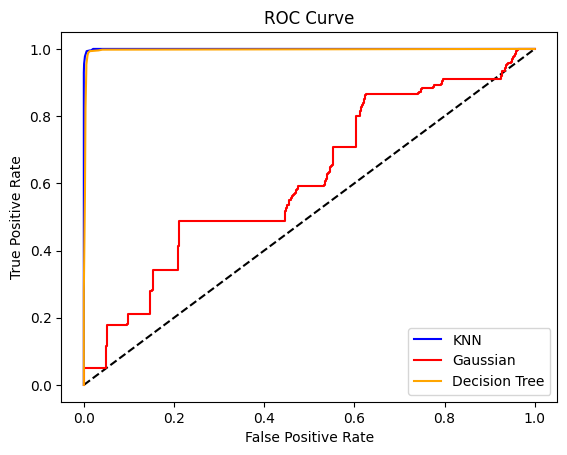

ROC AUC Scores: {'KNN': 0.9997858687168011, 'Gaussian': 0.614627238880715, 'Decision Tree': 0.9966270869165785}
Best ROC AUC: KNN : 0.9997858687168011


In [267]:
roc_scores = {}
def plot_roc_curve(y_val, y_pred, color, name):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, color=color, label=name)
    roc_scores[name] = roc_auc_score(y_val, y_pred)


knn_probs = best_knn.predict_proba(X_validate)[:, 1]
gaussian_val_probs = naive_bayes_model.predict_proba(X_validate)[:, 1]
decision_tree_val_probs = decision_tree.predict_proba(X_validate)[:, 1]

plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(y_validate, knn_probs, 'blue', "KNN")
plot_roc_curve(y_validate, gaussian_val_probs, 'red', "Gaussian")
plot_roc_curve(y_validate, decision_tree_val_probs, 'orange', "Decision Tree")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
best_roc = max(roc_scores, key=roc_scores.get)
print(f"ROC AUC Scores: {roc_scores}\nBest ROC AUC: {best_roc} : {roc_scores[best_roc]}")

## Test

In [268]:
best_model = best_knn

y_final_pred = best_model.predict(X_test)

best_confusion = confusion_matrix(y_test, y_final_pred)
print_metrics("Best Model", y_test, y_final_pred, best_confusion)

Best Model: 
	Accuracy Score: 0.9919747081712063
	Precision Score: 0.9761163032191069
	Recall Score: 0.9894736842105263
	Specificity: 0.9927261227071473
	F1 Score: 0.9827496079456352
